### Imports

In [291]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import get_scorer_names
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.decomposition import PCA

### Reading and inspecting the data

In [292]:
boat_data = pd.read_csv('data/boat_data.csv')

print(boat_data.describe())
print(boat_data.info())
print(boat_data.head())

        Year Built       Length        Width  Number of views last 7 days
count  9888.000000  9879.000000  9832.000000                  9888.000000
mean   1893.192860    11.570017     3.520124                   149.160801
std     460.201582     6.002820     1.220534                   151.819752
min       0.000000     1.040000     0.010000                    13.000000
25%    1996.000000     7.470000     2.540000                    70.000000
50%    2007.000000    10.280000     3.330000                   108.000000
75%    2017.000000    13.930000     4.250000                   172.000000
max    2021.000000   100.000000    25.160000                  3263.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9888 entries, 0 to 9887
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Price                        9888 non-null   object 
 1   Boat Type                    9888 non-null   obj

# Data Preprocessing

In [293]:
# check for null values
print(boat_data.isna().sum())

# counting unique values in each column
for col in boat_data:
	print("{}: {}".format(col, len(boat_data[col].unique())))
    
# since there are so few, drop rows with null values for type, length, width and location
boat_data.dropna(axis=0, how='any', subset=['Type', 'Length', 'Width', 'Location'], inplace=True)

# check again for null values
print(boat_data.isna().sum())

# print rows with null manufacturers
print(boat_data[boat_data['Manufacturer'].isna()])
    

Price                             0
Boat Type                         0
Manufacturer                   1338
Type                              6
Year Built                        0
Length                            9
Width                            56
Material                       1749
Location                         36
Number of views last 7 days       0
dtype: int64
Price: 3182
Boat Type: 126
Manufacturer: 911
Type: 25
Year Built: 122
Length: 1613
Width: 576
Material: 12
Location: 2996
Number of views last 7 days: 674
Price                             0
Boat Type                         0
Manufacturer                   1314
Type                              0
Year Built                        0
Length                            0
Width                             0
Material                       1712
Location                          0
Number of views last 7 days       0
dtype: int64
          Price     Boat Type Manufacturer                          Type  \
6      CHF 3600     Cat

In [294]:
# fix dtypes according to spec
print(boat_data.dtypes)

boat_data = boat_data.astype({'Boat Type': 'category', 'Manufacturer': 'category', 'Type': 'category',
                       'Material': 'category', 'Location': 'string'})

print(boat_data.dtypes)


Price                           object
Boat Type                       object
Manufacturer                    object
Type                            object
Year Built                       int64
Length                         float64
Width                          float64
Material                        object
Location                        object
Number of views last 7 days      int64
dtype: object
Price                            object
Boat Type                      category
Manufacturer                   category
Type                           category
Year Built                        int64
Length                          float64
Width                           float64
Material                       category
Location                         string
Number of views last 7 days       int64
dtype: object


## Calculating Manufacturer and Material based on other data from other rows

Since there is such a large amount of data missing from both the Material and Manufacturer columns I will attempt calculate these values rather than perform a forward/backward fill. Assuming that entries with matching Price, Boat Type, Type, Year Built, Width and Length values are made by the same manufacturer we can fill in these values. The same assumption can be made for the Material column

In [295]:
manufacturers = boat_data['Manufacturer']
materials = boat_data['Material']

# boat data without Manufacturer and Material columns
boat_data_no_man_mat = boat_data.drop(columns=['Manufacturer', 'Material'])

# only rows with null values in the Manufacturer and Material columns
null_man_mat = boat_data[boat_data['Manufacturer'].isna() | boat_data['Material'].isna()]

# boat_data without any missing Manufacturer or Material values
boat_no_null_man_mat = boat_data.drop(index=null_man_mat.index)

null_man_mat.drop(columns=['Manufacturer', 'Material'], inplace=True)

total = 0

# check for rows matching the data with missing Manufacturer and Material values
for i, r in null_man_mat.iterrows():
    query = (boat_no_null_man_mat['Price'] == r['Price']) & (boat_no_null_man_mat['Boat Type'] == r['Boat Type']) & \
        (boat_no_null_man_mat['Type'] == r['Type']) & (boat_no_null_man_mat['Year Built'] == r['Year Built']) & \
        (boat_no_null_man_mat['Width'] == r['Width']) & (boat_no_null_man_mat['Length'] == r['Length'])
    
    if (query).any():
        index = boat_no_null_man_mat[query].index.tolist()
        man, mat = boat_data.iloc[i][['Manufacturer', 'Material']]
        total += 1

print("Total matches: {}\n".format(total))
# results in 20 matches, however execution is slow so I have commented out the snippet for now

total_datapoints = boat_data.count().sum()
print('Total Datapoints: {}'.format(total_datapoints))

datapoints_in_null_rows = null_man_mat.count().sum()
print('Datapoints lost dropping rows: {}'.format(datapoints_in_null_rows))

datapoints_in_manufacturers = boat_data['Manufacturer'].dropna().count().sum()
datapoints_in_materials = boat_data['Material'].dropna().count().sum()
total_datapoints_in_man_mat = datapoints_in_manufacturers + datapoints_in_materials
print('Datapoints lost dropping columns: {}'.format(total_datapoints_in_man_mat))


print("Percentage of data lost dropping columns: {:.2f}%".format((total_datapoints_in_man_mat / total_datapoints)*100))
print("Percentage of data lost dropping rows: {:.2f}%".format((datapoints_in_null_rows / total_datapoints)*100))

Total matches: 20

Total Datapoints: 94874
Datapoints lost dropping rows: 22168
Datapoints lost dropping columns: 16554
Percentage of data lost dropping columns: 17.45%
Percentage of data lost dropping rows: 23.37%


Analysis has found 20 matching entries with missing null manufacturer and material values. Replacing these null values would not sufficiently impact the number of missing entries from the Manufacturer or Material columns.

Now we have 2 possible approches, either remove the 'Material' and 'Manufacturer' columns, or to remove the rows containing null values. It is shown at the end of the analysis that droppings both columns would result in a 17% loss in data whereas dropping the rows containing null values would give a 23% data loss. Therefore, going forward I will choose to remove the 'Material' and 'Manufacturer' columns.

If sufficient accuracy cannot be achieved after further cleaning I will consider the alternative approach of dropping the rows containing null values to see if a superior model can be trained.

A third possible solution is to re-introduce these values and train a regressor that can appropriately handle null values such as a RandomForesetRegressor or XGBoostRegressor

In [296]:
boat_data.drop(columns=['Manufacturer', 'Material'], inplace=True)

print(boat_data.describe())
print(boat_data.info())

        Year Built       Length        Width  Number of views last 7 days
count  9790.000000  9790.000000  9790.000000                  9790.000000
mean   1892.499387    11.537413     3.514004                   149.366803
std     461.575903     5.970952     1.213858                   152.243472
min       0.000000     1.040000     0.010000                    13.000000
25%    1996.000000     7.460000     2.540000                    70.000000
50%    2007.000000    10.245000     3.320000                   108.000000
75%    2017.000000    13.900000     4.250000                   172.000000
max    2021.000000   100.000000    25.160000                  3263.000000
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9790 entries, 0 to 9887
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   Price                        9790 non-null   object  
 1   Boat Type                    9790 non-null   c

## Cleaning the 'Year Built' column

count    9790.000000
mean     1892.499387
std       461.575903
min         0.000000
25%      1996.000000
50%      2007.000000
75%      2017.000000
max      2021.000000
Name: Year Built, dtype: float64


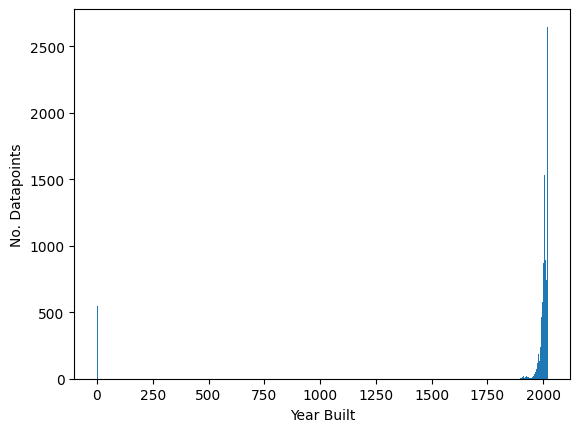

Number of values with a year built of 0: 549


In [297]:
print(boat_data['Year Built'].describe())

ax = plt.hist(x=boat_data['Year Built'], bins = 500)
plt.xlabel('Year Built')
plt.ylabel("No. Datapoints")
plt.show()

print('Number of values with a year built of 0: {}'.format(boat_data['Year Built'].loc[boat_data['Year Built'] == 0].count()))

The countplot above shows the distribution of "Year Built" values across the dataset. The graph and some calculation shows that there are 549 values have a year built of 0. This is clearly incorrect and so the data will need to be cleaned. We can also see that the 25th percentile of data is 1996 which seems like an appropriate year built. This suggests that rows with year built values slightly above 0 may also need to be cleaned

In [298]:
twenty_fifth = np.percentile(boat_data['Year Built'], 5.6)
lowest = boat_data.nsmallest(550, 'Year Built').nlargest(2, 'Year Built')
print('549th lowest entry: {}'.format(lowest.iloc[1]['Year Built']))
print('550th lowest entry: {}'.format(lowest.iloc[0]['Year Built']))
print("25t Percentile: {}".format(twenty_fifth))

549th lowest entry: 0
550th lowest entry: 1885
25t Percentile: 346.8399999999417


The snippet above shows that the lowest 549 datapoints are 0, and the 550th datapoint is 1885 which is an appropriate Year Built for a historic boat for sale. Therefore I will remove the 549 smallest rows of data to remove null values

In [299]:
# remove the 0 values for Year Built

print(boat_data.info())

boat_data = boat_data[boat_data['Year Built'] != 0]

# Inspect the data
print(boat_data.info())
print(boat_data.describe())
print(boat_data.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9790 entries, 0 to 9887
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   Price                        9790 non-null   object  
 1   Boat Type                    9790 non-null   category
 2   Type                         9790 non-null   category
 3   Year Built                   9790 non-null   int64   
 4   Length                       9790 non-null   float64 
 5   Width                        9790 non-null   float64 
 6   Location                     9790 non-null   string  
 7   Number of views last 7 days  9790 non-null   int64   
dtypes: category(2), float64(2), int64(2), object(1), string(1)
memory usage: 818.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9241 entries, 0 to 9887
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       ------------

## Cleaning Location and Price columns

To process the Price column I will separate the value and the currency into separate columns in hope that my regressor will be able to recognise the relationship between the different currencies and their differing scales. I could convert all currencies to the same currency, however this would introduce inaccuracy into the dataset because of how exchange rates change over time. I could not guarantee that each price was converted using the same conversion rates

For location, I will begin by splitting into 3 columns, Country, Municipality and Town. I will then remove all garbage characters and analyse null values

In [300]:
# separating the currency and value into separate columns in 

split = boat_data['Price'].str.split(expand=True)
boat_data[['Currency', 'Price']] = split

# replace broken symbol and £ symbol with character representatiuon "GBP" to ensure data consistency
boat_data['Currency'] = boat_data['Currency'].str.replace("Â£", "GBP")

# convert Price col to type float, currency to categorical

boat_data['Price'] = boat_data['Price'].astype('float')
boat_data['Currency'] = boat_data['Currency'].astype('category')

split = boat_data['Location'].str.split('Â»', expand=True)
boat_data[['Country', 'Municipality', 'Town']] = split

boat_data.drop(columns=['Location'], inplace=True)
print(boat_data.head())

boat_data[['Country', 'Municipality', 'Town']] = boat_data[['Country', 'Municipality', 'Town']].astype('category')

# check for null values

print(boat_data.isna().sum())

# drop the Town col since most of the data is empty

boat_data.drop(columns=['Town'], inplace=True)

print(boat_data.isna().sum())

# since only 842 rows are missing municipalities I will drop these rows to mantain information

boat_data.dropna(axis=0, subset='Municipality', inplace=True)

print(boat_data.isna().sum())

print(len(boat_data['Municipality'].unique()))

# Due to the large number of Municipalities I will drop this column as there are too many options to have a significant impace on the training of the data

boat_data.drop(columns=['Municipality'], inplace=True)

     Price            Boat Type                 Type  Year Built  Length  \
0   3337.0          Motor Yacht  new boat from stock        2017    4.00   
1   3490.0  Center console boat  new boat from stock        2020    4.00   
3  25900.0           Sport Boat  new boat from stock        2020    3.00   
4   3399.0         Fishing Boat  new boat from stock        2019    3.55   
6   3600.0            Catamaran   Used boat,Unleaded        1999    6.20   

   Width  Number of views last 7 days Currency       Country  \
0   1.90                          226      CHF  Switzerland    
1   1.50                           75      EUR      Germany    
3   1.00                           64      DKK      Denmark    
4   1.46                           58      EUR      Germany    
6   2.38                          474      CHF  Switzerland    

       Municipality       Town  
0      Lake Geneva    VÃ©senaz  
1     BÃ¶nningstedt       <NA>  
3         Svendborg       <NA>  
4           Bayern    MÃ¼n

## Checking quality of length and width data

Here I will check the quality of the length and width data. I will also create a new column, Area which will equal Length * Width for use in the regression Estimator later on

In [301]:
print(boat_data[['Length', 'Width']].describe())

# The data seems reasonable so I will calculate the Area column

boat_data['Area'] = boat_data['Length'] * boat_data['Width']

print(boat_data.head())

            Length        Width
count  8399.000000  8399.000000
mean     11.365563     3.478445
std       5.775593     1.172903
min       1.040000     0.500000
25%       7.485000     2.540000
50%      10.170000     3.300000
75%      13.675000     4.200000
max     100.000000    25.160000
     Price            Boat Type                 Type  Year Built  Length  \
0   3337.0          Motor Yacht  new boat from stock        2017    4.00   
1   3490.0  Center console boat  new boat from stock        2020    4.00   
3  25900.0           Sport Boat  new boat from stock        2020    3.00   
4   3399.0         Fishing Boat  new boat from stock        2019    3.55   
6   3600.0            Catamaran   Used boat,Unleaded        1999    6.20   

   Width  Number of views last 7 days Currency       Country    Area  
0   1.90                          226      CHF  Switzerland    7.600  
1   1.50                           75      EUR      Germany    6.000  
3   1.00                           64     

# Exploratory Data Analysis

In this section of my report I will begin to perform some exploratory data analysis in order to extract potential relationships from the data.

## 1. Price vs No. Views

A clear first comparison will be the Price of each boat compared to the Number of Views its post will generate

Since both of the variables are continuous, I will plot a scatterplot, and calculate the Pearson Corellation Coefficient to show the strength of correlation between the variables.

Since I did not convert the values of each price into the same currency, I will prepare separate visuals for each currency

['CHF', 'EUR', 'DKK', 'GBP']
Categories (4, object): ['CHF', 'DKK', 'EUR', 'GBP']


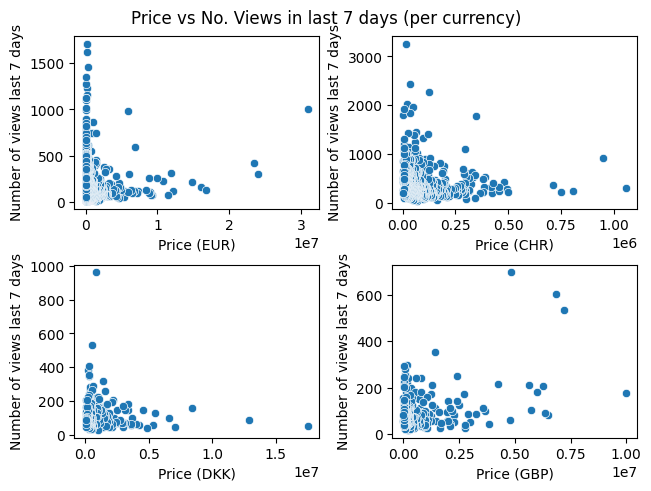

In [302]:
currencies = boat_data['Currency'].unique()

eur = boat_data[boat_data['Currency'] == 'EUR']
chf = boat_data[boat_data['Currency'] == 'CHF']
dkk = boat_data[boat_data['Currency'] == 'DKK']
gbp = boat_data[boat_data['Currency'] == 'GBP']

print(currencies)

fig, axes = plt.subplots(2, 2, constrained_layout=True)
fig.suptitle('Price vs No. Views in last 7 days (per currency)')

sns.scatterplot(ax=axes[0, 0], x='Price', y='Number of views last 7 days', data=eur, palette='b')
axes[0,0].set(xlabel='Price (EUR)')
sns.scatterplot(ax=axes[0, 1], x='Price', y='Number of views last 7 days', data=chf, palette='r')
axes[0,1].set(xlabel='Price (CHR)')
sns.scatterplot(ax=axes[1, 0], x='Price', y='Number of views last 7 days', data=dkk, palette='g')
axes[1,0].set(xlabel='Price (DKK)')
sns.scatterplot(ax=axes[1, 1], x='Price', y='Number of views last 7 days', data=gbp, palette='y')
axes[1,1].set(xlabel='Price (GBP)')

# ax.set(xscale='log')
# plt.ticklabel_format(style='plain', axis='x')

plt.show()

The graphs seem to show that the higher the price of a boat listing, the fewer views its listing will get. However it is also shown in the graphs that the data is distributed much more greatly towards the lower end of the Y axis. This could be causing the relationships to be unclear, so I will check the data within the IQR and see if thse relationships

['CHF', 'EUR', 'DKK', 'GBP']
Categories (4, object): ['CHF', 'DKK', 'EUR', 'GBP']


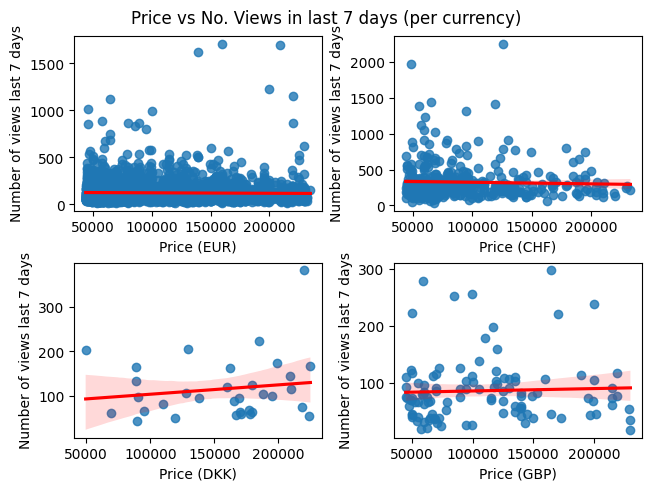

In [303]:
# separate into differenct currencies and remove values lower than the 25th percentile and higher than the 75th percentile

currencies = boat_data['Currency'].unique()

eur_iqr = boat_data[(boat_data['Currency'] == 'EUR') & (boat_data['Price'] > np.percentile(boat_data['Price'], 25)) & (boat_data['Price'] < np.percentile(boat_data['Price'], 75))]
chf_iqr = boat_data[(boat_data['Currency'] == 'CHF') & (boat_data['Price'] > np.percentile(boat_data['Price'], 25)) & (boat_data['Price'] < np.percentile(boat_data['Price'], 75))]
dkk_iqr = boat_data[(boat_data['Currency'] == 'DKK') & (boat_data['Price'] > np.percentile(boat_data['Price'], 25)) & (boat_data['Price'] < np.percentile(boat_data['Price'], 75))]
gbp_iqr = boat_data[(boat_data['Currency'] == 'GBP') & (boat_data['Price'] > np.percentile(boat_data['Price'], 25)) & (boat_data['Price'] < np.percentile(boat_data['Price'], 75))]

print(currencies)

fig, axes = plt.subplots(2, 2, constrained_layout=True)
fig.suptitle('Price vs No. Views in last 7 days (per currency)')

sns.regplot(ax=axes[0, 0], x='Price', y='Number of views last 7 days', data=eur_iqr, label='EUR', line_kws={"color": "red"})
axes[0,0].set(xlabel='Price (EUR)')
sns.regplot(ax=axes[0, 1], x='Price', y='Number of views last 7 days', data=chf_iqr, label='CHF', line_kws={"color": "red"})
axes[0,1].set(xlabel='Price (CHF)')
sns.regplot(ax=axes[1, 0], x='Price', y='Number of views last 7 days', data=dkk_iqr, label='DKK', line_kws={"color": "red"})
axes[1,0].set(xlabel='Price (DKK)')
sns.regplot(ax=axes[1, 1], x='Price', y='Number of views last 7 days', data=gbp_iqr, label='GBP', line_kws={"color": "red"})
axes[1,1].set(xlabel='Price (GBP)')

plt.show()

Observing the lines of regression on these 4 graphs, it doesn't suggest that there is much correlation between the variables. I will confirm this by calculating the Pearson Corellation Coefficients for each currency

### Calculating Pearson Corellation Coefficients

In [304]:
# 1. euros

eur_coef = eur[['Price', 'Number of views last 7 days']].corr(method='pearson')
print("EUR: {}".format(eur_coef))

# 2. francs

chf_coef = chf[['Price', 'Number of views last 7 days']].corr(method='pearson')
print("CHF: {}".format(chf_coef))

# 3. krone

dkk_coef = dkk[['Price', 'Number of views last 7 days']].corr(method='pearson')
print("DKK: {}".format(dkk_coef))

# 4. pounds

gbp_coef = gbp[['Price', 'Number of views last 7 days']].corr(method='pearson')
print("GBP: {}".format(gbp_coef))

# 5. total 

boat_coef = boat_data[['Price', 'Number of views last 7 days']].corr(method='pearson')
print("Total: {}".format(boat_coef))

EUR:                                 Price  Number of views last 7 days
Price                        1.000000                     0.044549
Number of views last 7 days  0.044549                     1.000000
CHF:                                 Price  Number of views last 7 days
Price                        1.000000                    -0.055587
Number of views last 7 days -0.055587                     1.000000
DKK:                                 Price  Number of views last 7 days
Price                        1.000000                    -0.111689
Number of views last 7 days -0.111689                     1.000000
GBP:                                 Price  Number of views last 7 days
Price                        1.000000                     0.379131
Number of views last 7 days  0.379131                     1.000000
Total:                                 Price  Number of views last 7 days
Price                        1.000000                    -0.008915
Number of views last 7 days -0.0089

After calculating the coefficients of correlation, all except DKK have values less than or close to 0.05. This suggests no linear correlation between the variables within the full set of data. This suggests a non-linear model will be best used to predict the number of views

The coefficient for GBP is comparatively high, however there are few datapoints with pounds as a currency and therefore this will be significantly less accruate than the coefficient for datapoints using euros

## 2. Location vs No. Views

Location is a discrete variable and therefore we will need a different type of visualisation to view the relationships. 

['Motor Yacht', 'Center console boat', 'Sport Boat', 'Fishing Boat', 'Catamaran', ..., 'Deck Boat,Water ski', 'Classic,Fishing Boat', 'Hardtop,Sport Boat', 'Cabin Boat,Fishing Boat,Sport Boat', 'Classic,Runabout,Trawler']
Length: 120
Categories (126, object): ['Bowrider', 'Bowrider,Cabin Boat,Deck Boat', 'Bowrider,Center console boat,Sport Boat', 'Bowrider,Classic', ..., 'Wakeboard/Wakesurf', 'Wakeboard/Wakesurf,Water ski', 'Water ski', 'Working Boat']


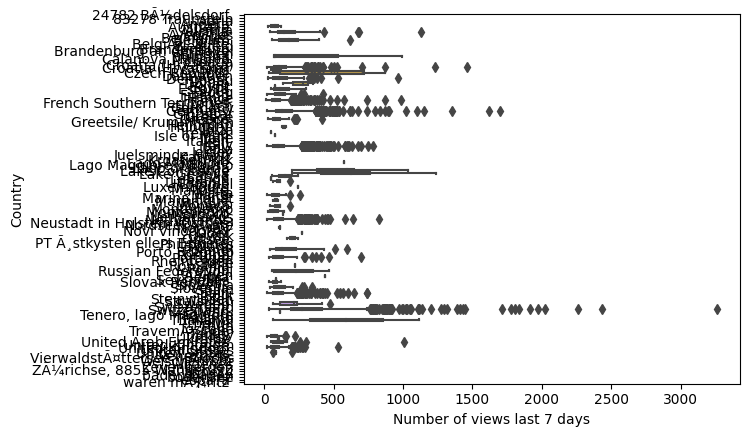

In [305]:
countries = boat_data['Boat Type'].unique()
print(countries)

# print(boat_data)
sns.boxplot(y='Country', x='Number of views last 7 days', data=boat_data)
plt.show()

This graph doesn't show us too much, however we can see that generally the IQR for some countries is higher than others. This suggests that there are countries with higher distriuted values of views on their boat listings than others. The relationship is not clear however and so hopefully a non-linear model will be exctract the information it needs

## 3. Width, Length, Area vs No. Views

Now we will explore width, length and area with number of views.

[Text(0.5, 0, 'Area (m^2)'), Text(0, 0.5, '')]

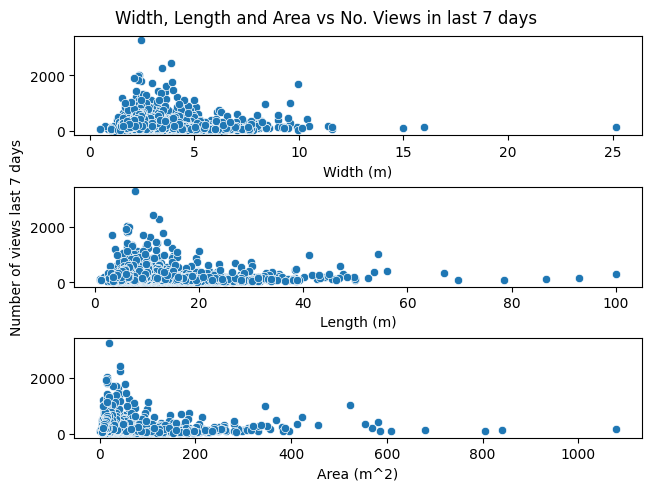

In [306]:
fig, axes = plt.subplots(3, 1, constrained_layout=True, sharey=True)
fig.suptitle('Width, Length and Area vs No. Views in last 7 days')

sns.scatterplot(ax=axes[0], x='Width', y='Number of views last 7 days', data=boat_data)
sns.scatterplot(ax=axes[1], x='Length', y='Number of views last 7 days', data=boat_data)
sns.scatterplot(ax=axes[2], x='Area', y='Number of views last 7 days', data=boat_data)

axes[0].set(xlabel='Width (m)', ylabel='')
axes[1].set(xlabel='Length (m)', ylabel='Number of views last 7 days')
axes[2].set(xlabel='Area (m^2)', ylabel='')



These graphs all support the same suggestion, that there is a clear relationship between width, length and area when compared to the number of views. This could be slightly skewed by the lack of data at the extremes of these values, however the pattern can still be seen in the lower ranges of the graphs.

## 4. Boat Type and Type vs Num Views

Using the pandas explode() function I can split datapoints containing multiple entries (e.g. strings separated by commas) while preserving the index, this will allow the regressor to process the rows containing multiple values

In [307]:
# split Boat Type and Type on commas

boat_data['Boat Type'] = boat_data['Boat Type'].str.split(',')
boat_data['Type'] = boat_data['Type'].str.split(',')

types = boat_data['Type']
boat_types = boat_data['Boat Type']

print(types)
print(boat_types)

# explode into multiple rows (with the same index) separating each category
boat_data = boat_data.explode(['Boat Type'])
boat_data = boat_data.explode(['Type'])

print(boat_data.info())

# change dtype to categorical
boat_data[['Boat Type', 'Type']] = boat_data[['Boat Type', 'Type']].astype('category')

0                 [new boat from stock]
1                 [new boat from stock]
3                 [new boat from stock]
4                 [new boat from stock]
6                 [Used boat, Unleaded]
                     ...               
9882              [Used boat, Unleaded]
9883              [Used boat, Unleaded]
9885    [new boat from stock, Unleaded]
9886              [new boat from stock]
9887              [new boat from stock]
Name: Type, Length: 8399, dtype: object
0               [Motor Yacht]
1       [Center console boat]
3                [Sport Boat]
4              [Fishing Boat]
6                 [Catamaran]
                ...          
9882           [Fishing Boat]
9883             [Sport Boat]
9885             [Sport Boat]
9886           [Pontoon Boat]
9887           [Fishing Boat]
Name: Boat Type, Length: 8399, dtype: object
<class 'pandas.core.frame.DataFrame'>
Int64Index: 15574 entries, 0 to 9887
Data columns (total 10 columns):
 #   Column                       Non

['new boat from stock', 'Used boat', 'Unleaded', 'Electric', 'Diesel', 'new boat on order', 'Gas', 'Display Model', 'Hybrid', 'Propane']
Categories (10, object): ['Diesel', 'Display Model', 'Electric', 'Gas', ..., 'Unleaded', 'Used boat', 'new boat from stock', 'new boat on order']
['Motor Yacht', 'Center console boat', 'Sport Boat', 'Fishing Boat', 'Catamaran', ..., 'Passenger boat', 'House Boat', 'Motorsailer', 'Mega Yacht', 'RIB']
Length: 25
Categories (25, object): ['Bowrider', 'Cabin Boat', 'Catamaran', 'Center console boat', ..., 'Trawler', 'Wakeboard/Wakesurf', 'Water ski', 'Working Boat']


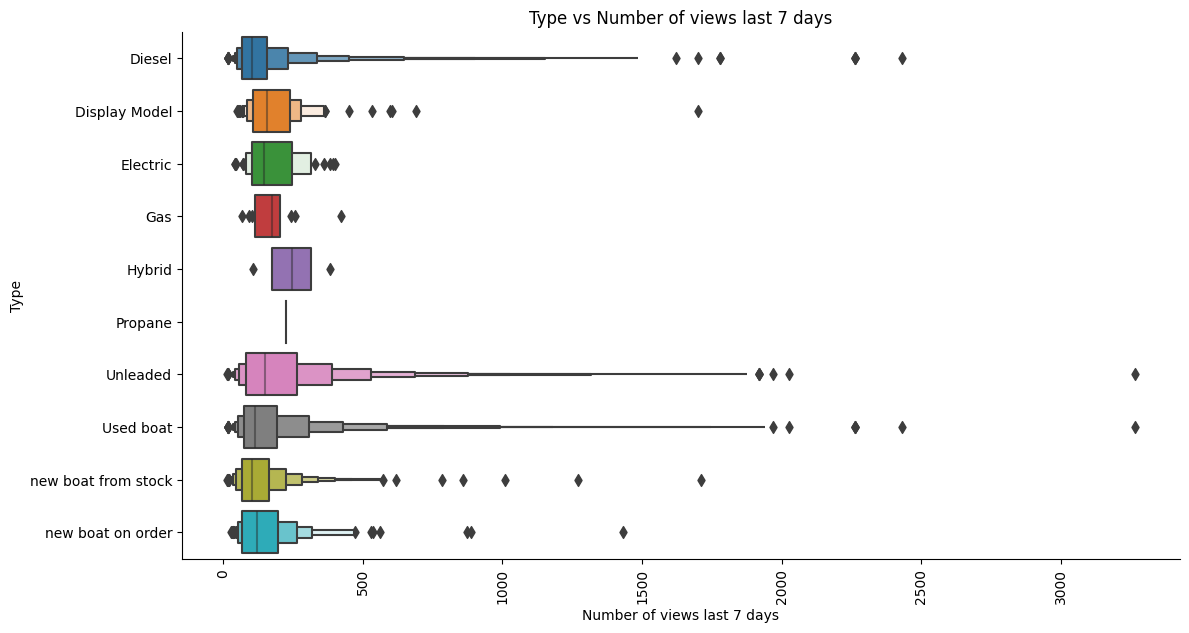

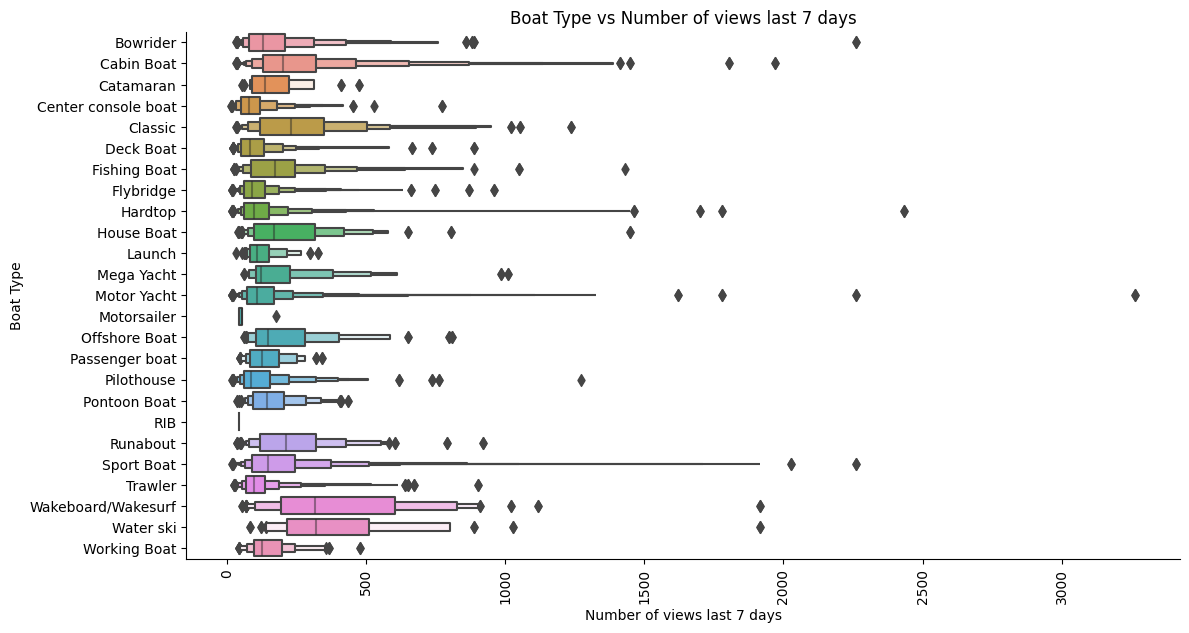

In [308]:
# check unique values for type and boat_type
types = boat_data['Type'].unique()
boat_types = boat_data['Boat Type'].unique()

print(types)
print(boat_types)

sns.catplot(kind='boxen', y='Type', x='Number of views last 7 days', data=boat_data, height=6, aspect=2)

plt.xticks(rotation=90)
plt.title('Type vs Number of views last 7 days')
plt.show()

sns.catplot(kind='boxen', y='Boat Type', x='Number of views last 7 days', data=boat_data, height=6, aspect=2)

plt.xticks(rotation=90)
plt.title('Boat Type vs Number of views last 7 days')


plt.show()

Similarly to the country EDA we can see that certain Boat Types and Types do attract more views to their profile. Looking at Type we can see that some represent fuel types. The plot shows that Petrol draws the most interest, followed by Diesel, then Electric and so on.

From the boat type plot we can see that the IQR for certain types is significantly higher, such as Runabout whuch makes sense because this would be the type of boat everyday people would own. Wakeboard and Water Skis were also high since these are smaller vehicles and therefore might be more affordable by the average person.

# Model Fitting

Now we have performed some EDA we can begin to consider different models that might best fit our data. The business task was to predict the number of views that a boat listing would draw within 50% accuracy. Since Number of Views in the last 7 days is a continuous variable this is a regression task and so we will attempt to train a sklean Regression Estimator to our data

I will try traditional regressors and if I cannot reach a suitable accuracy then I will reintroduce the Manufacturer and Material columns and attempt to use models such as RandomForestRegressor

## Processing Categorical Data

Before we can train the data I must encode the caterogical variables so that they can be interpreted by the Regression estimators from sklearn. Possible options include:

1. One hot encoding (get_dummies): This approach is commonly used to encode categories by creating a column for each category. This works effectively for datasets with few categories, however there are many different Types and Boat Types in our dataset. This would leave us with an unreasonable number of columns and could negatively impact the accuracy of our Regressor. To deal with this one option would be to only use one hot encoding on the 10 most frequent categories.

2. Ordinal encoding: This approach will assign an integer to each different category. This may not be sufficient for this dataset as it assumes there is an ordinal relationship between the categories such as Places: 1st, 2nd, 3rd..., rather than Red, Blue, Green

My first attempt will make use of the pd.get_dummies from Pandas

Since the success metric in the task is an accuracy of 50%, I will use the metric mean_absolute_percentage_error from sklearn.metrics. This will allow me to interpret the loss of my estimator and judge its success

In [309]:
boat_data = pd.get_dummies(boat_data, columns=['Type', 'Boat Type', 'Currency', 'Country'])

targets = boat_data['Number of views last 7 days']
features = boat_data.drop(columns=['Number of views last 7 days'])

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2)

## 1. LinearRegressor

Despite finding no linear relationships in the data, I will check to see how a LinearRegressor performs on the data

In [310]:
lin_reg = LinearRegression()

lin_reg.fit(X_train, y_train)

y_pred = lin_reg.predict(X_train)

mape = MAPE(y_train, y_pred)
print("Train set: {}".format(mape))

y_pred = lin_reg.predict(X_test)

mape = MAPE(y_test, y_pred)
print("Test set: {}".format(mape))

num_folds = 10

cv_score = cross_val_score(lin_reg, features, targets, cv=num_folds, scoring='neg_mean_absolute_percentage_error')
print("Cross Val Score: {}".format(cv_score))
print("Average Cross Val Score: {}".format(abs(sum(cv_score)/num_folds)))

Train set: 0.6504288730261641
Test set: 0.6281113304328197
Cross Val Score: [-0.55819662 -0.70426802 -0.72590105 -0.93758314 -0.69443109 -0.75701066
 -0.7176192  -0.70027091 -0.63483201 -0.48348527]
Average Cross Val Score: 0.6913597965733945


This is a very promising score from a linear regressor. On average the error was 69% and our goal is 50%. Next I will attempt to use a nonlinear regression model on our data

## 2. DecisionTreeRegressor

Decision trees interpret non-linear relationships much more effectively than LinearRegressionModelsin the data and so will hopefully achieve a higher score than 65%

In [311]:
# hyperparameters to GridSearch (max_depth, min_samples_split, min_samples_leaf, criterion)

dec_tree = DecisionTreeRegressor()

dec_tree.fit(X_train, y_train)

y_pred = dec_tree.predict(X_train)

mape = MAPE(y_train, y_pred)
print("Train set: {}".format(mape))

y_pred = dec_tree.predict(X_test)

mape = MAPE(y_test, y_pred)
print("Test set: {}".format(mape))

num_folds = 10

cv_score = cross_val_score(dec_tree, features, targets, cv=num_folds, scoring='neg_mean_absolute_percentage_error')
print("Cross Val Score: {}".format(cv_score))
print("Average Cross Val Score: {}".format(abs(sum(cv_score)/num_folds)))

Train set: 0.005499964305835337
Test set: 0.2294312352471318
Cross Val Score: [-0.69313885 -0.74654613 -0.70837189 -1.23454924 -0.71580792 -0.84257011
 -0.70352134 -0.77591719 -0.68564264 -0.69964709]
Average Cross Val Score: 0.7805712402170213


This model performs well on the train set, but less well on the testing set. This suggests overfitting. Using a cross fold method to evaluate the model shows that the average Mean Average Percentage Error is 75% which is higher than our linear regressor, therefore I will continue to testing our next regression model

## 3. RandomForestRegressor

In [312]:
# hyperparameters to GridSearch (max_depth, min_samples_split, min_samples_leaf, criterion)

rand_tree = RandomForestRegressor()

rand_tree.fit(X_train, y_train)

y_pred = rand_tree.predict(X_train)

mape = MAPE(y_train, y_pred)
print("Train set: {}".format(mape))

y_pred = rand_tree.predict(X_test)

mape = MAPE(y_test, y_pred)
print("Test set: {}".format(mape))

num_folds = 10

cv_score = cross_val_score(rand_tree, features, targets, cv=num_folds, scoring='neg_mean_absolute_percentage_error')
print("Cross Val Score: {}".format(cv_score))
print("Average Cross Val Score: {}".format(abs(sum(cv_score)/num_folds)))

Train set: 0.13106133071691453
Test set: 0.32165792402243676
Cross Val Score: [-0.59827341 -0.56887612 -0.6147258  -0.92756508 -0.55561418 -0.64512318
 -0.56446737 -0.61226831 -0.55840798 -0.54187399]
Average Cross Val Score: 0.6187195416624356


This model achieves an average cross fold score of 61% across 10 folds. This is very close to our success threshold and is much more accurate than both the DecisionTreeRegressor and the Linear Regressor which achieved scores of 77% and 69% respectively. 

Next steps I will use GridSearchCV and RandomGridSearchCV to tune the hyperparameters of the model, before considering dimensionality reduction

In [313]:
# params = {'criterion': ('squared_error', 'absolute_error', 'poisson'), 'max_depth': [1, 2, 4, 8, 16, 32], 'n_estimators': [1, 2, 4, 8, 16, 32, 64, 200, 400, 800], 'min_samples_split': np.linspace(0.1, 1, 10), 'min_samples_leaf': np.linspace(0.1, 0.5, 5)}

# random_search = GridSearchCV(rand_tree, params)
# search = random_search.fit(features, targets)
# print(search.best_params_)

rand_tree = RandomForestRegressor(criterion='absolute_error', max_depth=3, min_samples_split=0.1, n_estimators=100, n_jobs=5)

A limited GridSearchCV provides the above hyperparameters as the best options, resulting in an error of 52%. Which is very close to our target. I have commented out the code to increase the speed at which my notebook executes


## 4. Data Transforming

I will now use the MinMaxScaler to scale our data in hope that our Estimator can interpret the non-linear relationship more accurately

In [ ]:
minmax = MinMaxScaler()

X_train = minmax.fit_transform(X_train)

rand_tree.fit(X_train, y_train)

y_pred = rand_tree.predict(X_train)

mape = MAPE(y_train, y_pred)
print("Train set: {}".format(mape))

X_test = minmax.fit_transform(X_test)

y_pred = rand_tree.predict(X_test)

mape = MAPE(y_test, y_pred)
print("Test set: {}".format(mape))

Results: Train set: 0.514, Test set: 0.524

Using the minmax scaler didn't change too much so I will now try to use the StandardScaler

In [ ]:
std_scaler = StandardScaler()

X_train = std_scaler.fit_transform(X_train)

rand_tree.fit(X_train, y_train)

y_pred = rand_tree.predict(X_train)

mape = MAPE(y_train, y_pred)
print("Train set: {}".format(mape))

X_test = minmax.fit_transform(X_test)

y_pred = rand_tree.predict(X_test)

mape = MAPE(y_test, y_pred)
print("Test set: {}".format(mape))

Results: Train: 0.515, Test: 0.546

This actually decreased the accuracy on our test set. This is likely because the Standard Scaler assumes that the data is normally distributed and this was not clear from any of our EDA. The MinMaxScaler assumes the data is not normally distributed, hence the incrase in accuracy.

## 5. PCA
Taking this model further I will perform Principal Component Analysis and attempt to reduce the dimensitonality of our data. Before reducing the dimensionality of the data I will plot the variance of each component. This usually corresponds to the significance of each component in the model and therefore we can remove the least important components. Reducing dimensionality will hopefiully allow the model to extract the nonlinear relationship more easily

In [ ]:
pca = PCA()

std_scaler = StandardScaler()

# normalise the data so that the variance can be ordered by PCA
transformed = std_scaler.fit_transform(features)

pca.fit(transformed)

pca_features = range(pca.n_components_)

fig = plt.figure()
fig.set_size_inches(15, 6)

plt.bar(pca_features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(pca_features[::2], rotation=90)
plt.show()

As the graph shows, its is clear that most of the variables do not affect the training of the Estimator. Using the elbow rule we can decide how many components to use. In this case I estimat the elbow to cutoff at 10-12 components, so we will remove the remaining features and re-fit and evaluate our model.

In [ ]:
pca = PCA(n_components=178)

std_scaler = StandardScaler()

# normalise the data so that the variance can be ordered by PCA
transformed = std_scaler.fit_transform(features)

transformed = pca.fit_transform(transformed)

X_train, X_test, y_train, y_test = train_test_split(transformed, targets, test_size=0.2)

rand_tree.fit(X_train, y_train)

y_pred = rand_tree.predict(X_train)

mape = MAPE(y_train, y_pred)
print("Train set: {}".format(mape))

X_test = minmax.fit_transform(X_test)

y_pred = rand_tree.predict(X_test)

mape = MAPE(y_test, y_pred)
print("Test set: {}".format(mape))

Removing the features has caused lots of overfitting in my model and so I will discard this processing. This is likely due to the lack of linear correaltion between the variables in the data. PCA works best when the variables are correlated 

## 6. Reducing the size of the dataset

Looking at the graphs from our EDA we can see that ther are very few datapoints for listings with high numbers of views. The 75th Percentile of the data is 176 views and our max is 3263.

In order to increase the accuracy of our model I will remove the top standard deviation of data in order to reduce the effect of outliers on my model

In [210]:
# combining features and targets

features['Number of views last 7 days'] = targets
print(features.head())
print(features['Number of views last 7 days'])
tqr = np.percentile(features['Number of views last 7 days'], 75)
print("TQR: {}".format(tqr))

# removing data above the 75th percentile
features = features[features['Number of views last 7 days'] < np.percentile(features['Number of views last 7 days'], 75)]
targets = features['Number of views last 7 days']
features.drop(columns='Number of views last 7 days', inplace = True)

# recalculating the test/train sets
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2)

# reinstansiating my random forest regressor
rand_tree = RandomForestRegressor(criterion='absolute_error', max_depth=3, min_samples_split=0.1, n_estimators=100, n_jobs=5)

# scale the data
minmax = MinMaxScaler()

X_train = minmax.fit_transform(X_train)

rand_tree.fit(X_train, y_train)

# make predictions and evaluate
y_pred = rand_tree.predict(X_train)

mape = MAPE(y_train, y_pred)
print("Train set: {}".format(mape))

X_test = minmax.fit_transform(X_test)

y_pred = rand_tree.predict(X_test)

mape = MAPE(y_test, y_pred)
print("Test set: {}".format(mape))

Results: Train set: 0.425, Test set: 0.428

Removing the highest 25% of data has allowed us to create a model that meets the business target of 50%.

From this we can assume that inaccuracies in our previous models were caused by boat listings that recieived many views skewing the data.

# Evaluation and Conclusion

Our best model proved to be a RandomForestRegressor with the following parameters:

```
criterion='absolute_error'
max_depth=3
min_samples_split=0.1
n_estimators=100
```

I tried many approaches but due to the structure of our data, methods such as the StandardScaler only had a negative influence on my estimator. This was because the data was not normally distributed. The MinMaxScaler worked best because this assumes that the data is not normally distributed. It is however influenced greatly by outliers, so removing the top 25% of data meant this scaler could work much more effectively, shown by reaching an error of 43% on our test set. 

The top 25% of data aren't necessarily outliers, however there was a significant lack of data in the upper ranges. This can be seen in my EDA where most of the datapoints on the graphs were distributed towards the lower values.

The KPI for my models was the Mean Absolute Percentage Error. This was used to compare the models that I trained above. I chose my final model because it scored best on both the training dataset and the testing dataset. My DecisionTreeRegressor originally performed better on the train set that the RandomForestRegressor, however the RandomForestRegressor performed similarly well on both datasets. The difference in performance between training and testing sets is a sign of overfitting and the similarity between results in the RandomForestRegressor suggests that the model was better generalised to estimating number of views in the last 7 days.

## Future Work

### Hyperparameter Tuning

I was not fully able to tune the hyperparameters of my model due to restriction on computational resources and time. If I had more resources available to me then I would have been able to perform a full GridSearchCV on the parameter dictionary:

```
params = {'criterion': ('squared_error', 'absolute_error', 'poisson'),
'max_depth': [1, 2, 4, 8, 16, 32], 'n_estimators': [1, 2, 4, 8, 16, 32, 64, 200, 400, 800], 
'min_samples_split': np.linspace(0.1, 1, 10), 'min_samples_leaf': np.linspace(0.1, 0.5, 5)}
```

However with the available resources, this was not realistic within the timeframe.

Another restriction due to limited computational resources was my model evaluation. Ideally I would have also calculated Cross Validation Scores for my and Random Forest Regressors but this was also not possible within my time constraints.

### Further Data Collection

As discussed earlier, the upper 25% of was very unevenly distributed. This was causing the relationship to be misinterpreted. Removing this data allowed my model to perform much better, reaching the required business target of 50%.

This could be solved by collecting more datapoints from boat listings that are reciving higher number of views. Then data within these ranges can be retained when training the Estimators.

### Deep Learning Possibilities

There is always potential for better fitted models by using deep learning models. Neural Networks can capture more information from nonlinear relationships than simple machine learning soltutions, however this would also not be possible within the current timeframe or with the data that has currently been collected.